# Proyecto de Machine Learning: Predicción de Demanda de Bicicletas Compartidas

## Objetivo del Proyecto
Desarrollar un modelo de regresión para predecir la demanda de bicicletas compartidas basado en factores climáticos, temporales y estacionales.

## Dataset
- **Fuente**: UCI Machine Learning Repository - Bike Sharing Dataset
- **Instancias**: 17,389 registros
- **Características**: 13 features
- **Tarea**: Regresión
- **Periodo**: 2011-2012

## Fases del Proyecto
1. **Fase 1**: Análisis Exploratorio de Datos (EDA)
2. **Fase 2**: Preprocesamiento y Tratamiento de Datos
3. **Fase 3**: Modelado
4. **Fase 4**: Optimización

---

## Importacion de Librerias

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           confusion_matrix, classification_report, roc_auc_score, roc_curve)

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

from ucimlrepo import fetch_ucirepo

# Configuración de visualización
warnings.filterwarnings('ignore')
plt.style.use('default')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configuración de pandas para mostrar más columnas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


## Definicion de Funciones

#### 🔹 `plot_distribution(data, columns, target_col='target', figsize=(8, 4))`
Genera histogramas para comparar la distribución de múltiples variables numéricas (`columns`), separadas por clase según la variable objetivo (`target_col`). Útil para visualizar cómo varían las distribuciones entre clases o grupos.


#### 🔹 `plot_correlation_matrix(data, figsize=(8, 4))`
Genera un mapa de calor (heatmap) con la matriz de correlación de las variables numéricas del dataset. Muestra los valores de correlación y aplica una máscara para no duplicar información visualmente. Devuelve la matriz de correlación.


#### 🔹 `plot_outliers(data, columns, target_col='target', figsize=(8, 4))`
Genera boxplots por variable para detectar visualmente outliers en relación a una variable categórica o target. Útil para análisis exploratorio y limpieza de datos.


#### 🔹 `plot_class_balance(y, title="Distribución de Clases")`
Visualiza el balance de clases con dos gráficos: uno de barras (conteo) y uno de pastel (porcentaje). Ideal para tareas de clasificación, aunque puede reutilizarse para entender la distribución de cualquier variable categórica.


#### 🔹 `evaluate_model(model, X_test, y_test, y_pred, model_name)`
Calcula y devuelve un diccionario con tres métricas clave de regresión: MSE, R² y MAE, asociadas al nombre del modelo. Se usa para evaluación comparativa entre modelos.


#### 🔹 `plot_confusion_matrices(models_results, y_test, figsize=(15, 12))`
Genera matrices de confusión para múltiples modelos y las visualiza en un solo grid. Cada matriz muestra cómo se comporta un modelo clasificando correctamente o no. **Aplicable solo para clasificación**.


#### 🔹 `plot_roc_curves(models_results, y_test, figsize=(10, 8))`
Dibuja las curvas ROC de varios modelos, calculando AUC para cada uno. Permite evaluar visualmente la discriminación entre clases. **También específico para modelos de clasificación**.

In [4]:
def plot_distribution(data, columns, target_col='target', figsize=(8, 4)):
    n_cols = len(columns)
    n_rows = (n_cols + 2) // 3
    
    fig, axes = plt.subplots(n_rows, 3, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for i, col in enumerate(columns):
        if i < len(axes):
            # Histograma por clase
            for target_val in data[target_col].unique():
                subset = data[data[target_col] == target_val]
                axes[i].hist(subset[col], alpha=0.7, label=f'Clase {target_val}', bins=20)
            
            axes[i].set_title(f'Distribución de {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frecuencia')
            axes[i].legend()
    
    # Ocultar ejes vacíos
    for i in range(len(columns), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(data, figsize=(8, 4)):
    
    corr_matrix = data.corr(numeric_only=True)
    
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Generar heatmap
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdYlBu_r',
                center=0, square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    
    plt.title('Matriz de Correlación de Variables', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

def plot_outliers(data, columns, target_col='target', figsize=(8, 4)):
    n_cols = len(columns)
    n_rows = (n_cols + 2) // 3
    
    fig, axes = plt.subplots(n_rows, 3, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for i, col in enumerate(columns):
        if i < len(axes):
            sns.boxplot(data=data, x=target_col, y=col, ax=axes[i])
            axes[i].set_title(f'Boxplot de {col}')
    
    # Ocultar ejes vacíos
    for i in range(len(columns), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_class_balance(y, title="Distribución de Clases"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    
    # Gráfico de barras
    value_counts = y.value_counts()
    ax1.bar(value_counts.index, value_counts.values, color='skyblue')
    ax1.set_title(f'{title} - Conteo')
    ax1.set_xlabel('Clase')
    ax1.set_ylabel('Cantidad')
    
    for i, v in enumerate(value_counts.values):
        ax1.text(i, v + 5, str(v), ha='center', va='bottom')
    
    # Gráfico de pastel
    ax2.pie(value_counts.values, labels=[f'Clase {i}' for i in value_counts.index], 
            autopct='%1.1f%%', colors=sns.color_palette("pastel"))
    ax2.set_title(f'{title} - Porcentaje')
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_test, y_test, y_pred, model_name):
    
    results = {
        'Model': model_name,
        'MSE': mean_squared_error(y_test, y_pred),
        'r2': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred)
    }
    
    return results

def plot_confusion_matrices(models_results, y_test, figsize=(15, 12)):

    n_models = len(models_results)
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for i, (model_name, results) in enumerate(models_results.items()):
        if i < len(axes):
            y_pred = results['predictions']
            cm = confusion_matrix(y_test, y_pred)
            
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
            axes[i].set_title(f'Matriz de Confusión - {model_name}')
            axes[i].set_xlabel('Predicción')
            axes[i].set_ylabel('Real')
    
    # Ocultar ejes vacíos
    for i in range(len(models_results), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_roc_curves(models_results, y_test, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    
    for model_name, results in models_results.items():
        y_pred_proba = results.get('probabilities')
        if y_pred_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            auc_score = roc_auc_score(y_test, y_pred_proba)
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curvas ROC - Comparación de Modelos')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# FASE 1: ANÁLISIS EXPLORATORIO DE DATOS

## 1.1 Carga del Dataset

In [5]:
# 1.1 Carga de datos desde UCI ML Repository

# Obtener el dataset
bike_sharing = fetch_ucirepo(id=275)

# Extraer características y variable objetivo
X = bike_sharing.data.features
y = bike_sharing.data.targets

# Combinar en un solo DataFrame para el análisis
df = pd.concat([X, y], axis=1)

print(f"✅ Dataset cargado exitosamente!")
print(f"📈 Forma del dataset: {df.shape}")
print(f"🔗 Variables de entrada: {X.shape[1]}")
print(f"🎯 Variables objetivo: {y.shape[1]}")

✅ Dataset cargado exitosamente!
📈 Forma del dataset: (17379, 14)
🔗 Variables de entrada: 13
🎯 Variables objetivo: 1


## 1.2 Exploración inicial del dataset

In [6]:
# 1.2 Exploración inicial del dataset
print("🔍 EXPLORACIÓN INICIAL DEL DATASET")
print("=" * 50)

# Información general del dataset
print("📊 Información general:")
print(f"Forma del dataset: {df.shape}")
print(f"Número de filas: {df.shape[0]:,}")
print(f"Número de columnas: {df.shape[1]}")

🔍 EXPLORACIÓN INICIAL DEL DATASET
📊 Información general:
Forma del dataset: (17379, 14)
Número de filas: 17,379
Número de columnas: 14


### 1.2.1 Primeras 5 filas del dataset

In [13]:
print("\n📋 Primeras 5 filas del dataset:")
display(df.head())


📋 Primeras 5 filas del dataset:


,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


### 1.2.2 Ultimas 5 filas del dataset

In [14]:
print("\n📋 Últimas 5 filas del dataset:")
display(df.tail())


📋 Últimas 5 filas del dataset:


,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
17374,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,119
17375,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,89
17376,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,90
17377,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,61
17378,2012-12-31,1,1,12,23,0,1,1,1,0.26,0.2727,0.65,0.1343,49


### 1.2.3 Nombres de las columnas

In [12]:
print("\n🔗 Nombres de las columnas:")
print(df.columns.tolist())


🔗 Nombres de las columnas:
['dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']


## 1.3 Análisis de tipos de datos y valores faltantes

### 1.3.1 Información detallada del dataset

In [ ]:
# 1.3 Análisis de tipos de datos y valores faltantes
print("🔍 ANÁLISIS DE TIPOS DE DATOS Y CALIDAD")
print("=" * 50)

# Información detallada del dataset
print("📊 Información detallada:")
df.info()

🔍 ANÁLISIS DE TIPOS DE DATOS Y CALIDAD
📊 Información detallada:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      17379 non-null  object 
 1   season      17379 non-null  int64  
 2   yr          17379 non-null  int64  
 3   mnth        17379 non-null  int64  
 4   hr          17379 non-null  int64  
 5   holiday     17379 non-null  int64  
 6   weekday     17379 non-null  int64  
 7   workingday  17379 non-null  int64  
 8   weathersit  17379 non-null  int64  
 9   temp        17379 non-null  float64
 10  atemp       17379 non-null  float64
 11  hum         17379 non-null  float64
 12  windspeed   17379 non-null  float64
 13  cnt         17379 non-null  int64  
dtypes: float64(4), int64(9), object(1)
memory usage: 1.9+ MB


### 1.3.2 Tipos de datos

In [16]:
print("\n🔢 Tipos de datos:")
print(df.dtypes)


🔢 Tipos de datos:
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
cnt             int64
dtype: object


### 1.3.3 Valores nulos del dataset

In [17]:
print("\n❌ Valores faltantes por columna:")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Columna': missing_values.index,
    'Valores_Faltantes': missing_values.values,
    'Porcentaje': missing_percentage.values
})
print(missing_df)

print(f"\n📈 Total de valores faltantes: {df.isnull().sum().sum()}")
print(f"📊 Porcentaje total de valores faltantes: {(df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100:.2f}%")


❌ Valores faltantes por columna:
       Columna  Valores_Faltantes  Porcentaje
0       dteday                  0         0.0
1       season                  0         0.0
2           yr                  0         0.0
3         mnth                  0         0.0
4           hr                  0         0.0
5      holiday                  0         0.0
6      weekday                  0         0.0
7   workingday                  0         0.0
8   weathersit                  0         0.0
9         temp                  0         0.0
10       atemp                  0         0.0
11         hum                  0         0.0
12   windspeed                  0         0.0
13         cnt                  0         0.0

📈 Total de valores faltantes: 0
📊 Porcentaje total de valores faltantes: 0.00%


## 1.4 Estadísticas descriptivas

### 1.4.1 Estadísticas para variables numéricas

In [18]:
# 1.4 Estadísticas descriptivas
print("📊 ESTADÍSTICAS DESCRIPTIVAS")
print("=" * 50)

# Estadísticas para variables numéricas
print("🔢 Variables numéricas:")
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Columnas numéricas: {numeric_cols}")

print("\n📈 Estadísticas descriptivas de variables numéricas:")
display(df[numeric_cols].describe().round(4))

📊 ESTADÍSTICAS DESCRIPTIVAS
🔢 Variables numéricas:
Columnas numéricas: ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']

📈 Estadísticas descriptivas de variables numéricas:


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,17379.0000,17379.0000,17379.0000,17379.0000,17379.0000,17379.0000,17379.0000,17379.0000,17379.0000,17379.0000,17379.0000,17379.0000,17379.0000
mean,2.5016,0.5026,6.5378,11.5468,0.0288,3.0037,0.6827,1.4253,0.4970,0.4758,0.6272,0.1901,189.4631
std,1.1069,0.5000,3.4388,6.9144,0.1672,2.0058,0.4654,0.6394,0.1926,0.1719,0.1929,0.1223,181.3876
min,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0200,0.0000,0.0000,0.0000,1.0000
25%,2.0000,0.0000,4.0000,6.0000,0.0000,1.0000,0.0000,1.0000,0.3400,0.3333,0.4800,0.1045,40.0000
50%,3.0000,1.0000,7.0000,12.0000,0.0000,3.0000,1.0000,1.0000,0.5000,0.4848,0.6300,0.1940,142.0000
75%,3.0000,1.0000,10.0000,18.0000,0.0000,5.0000,1.0000,2.0000,0.6600,0.6212,0.7800,0.2537,281.0000
max,4.0000,1.0000,12.0000,23.0000,1.0000,6.0000,1.0000,4.0000,1.0000,1.0000,1.0000,0.8507,977.0000


### 1.4.2 Estadísticas para variables categóricas

In [19]:
# Estadísticas para variables categóricas
print("\n🏷️ Variables categóricas:")
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"Columnas categóricas: {categorical_cols}")

if categorical_cols:
    print("\n📊 Estadísticas descriptivas de variables categóricas:")
    display(df[categorical_cols].describe())
else:
    print("No hay variables categóricas de tipo object en el dataset.")


🏷️ Variables categóricas:
Columnas categóricas: ['dteday']

📊 Estadísticas descriptivas de variables categóricas:


,dteday
count,17379
unique,731
top,2012-12-31
freq,24


### 1.4.3 Información sobre la variable objetivo

In [20]:
# Información sobre la variable objetivo
print("\n🎯 ANÁLISIS DE LA VARIABLE OBJETIVO (cnt - Total Rental Bikes)")
print(f"Media: {df['cnt'].mean():.2f}")
print(f"Mediana: {df['cnt'].median():.2f}")
print(f"Desviación estándar: {df['cnt'].std():.2f}")
print(f"Mínimo: {df['cnt'].min()}")
print(f"Máximo: {df['cnt'].max()}")
print(f"Rango: {df['cnt'].max() - df['cnt'].min()}")


🎯 ANÁLISIS DE LA VARIABLE OBJETIVO (cnt - Total Rental Bikes)
Media: 189.46
Mediana: 142.00
Desviación estándar: 181.39
Mínimo: 1
Máximo: 977
Rango: 976


## 1.5 Análisis de distribuciones

📊 ANÁLISIS DE DISTRIBUCIONES


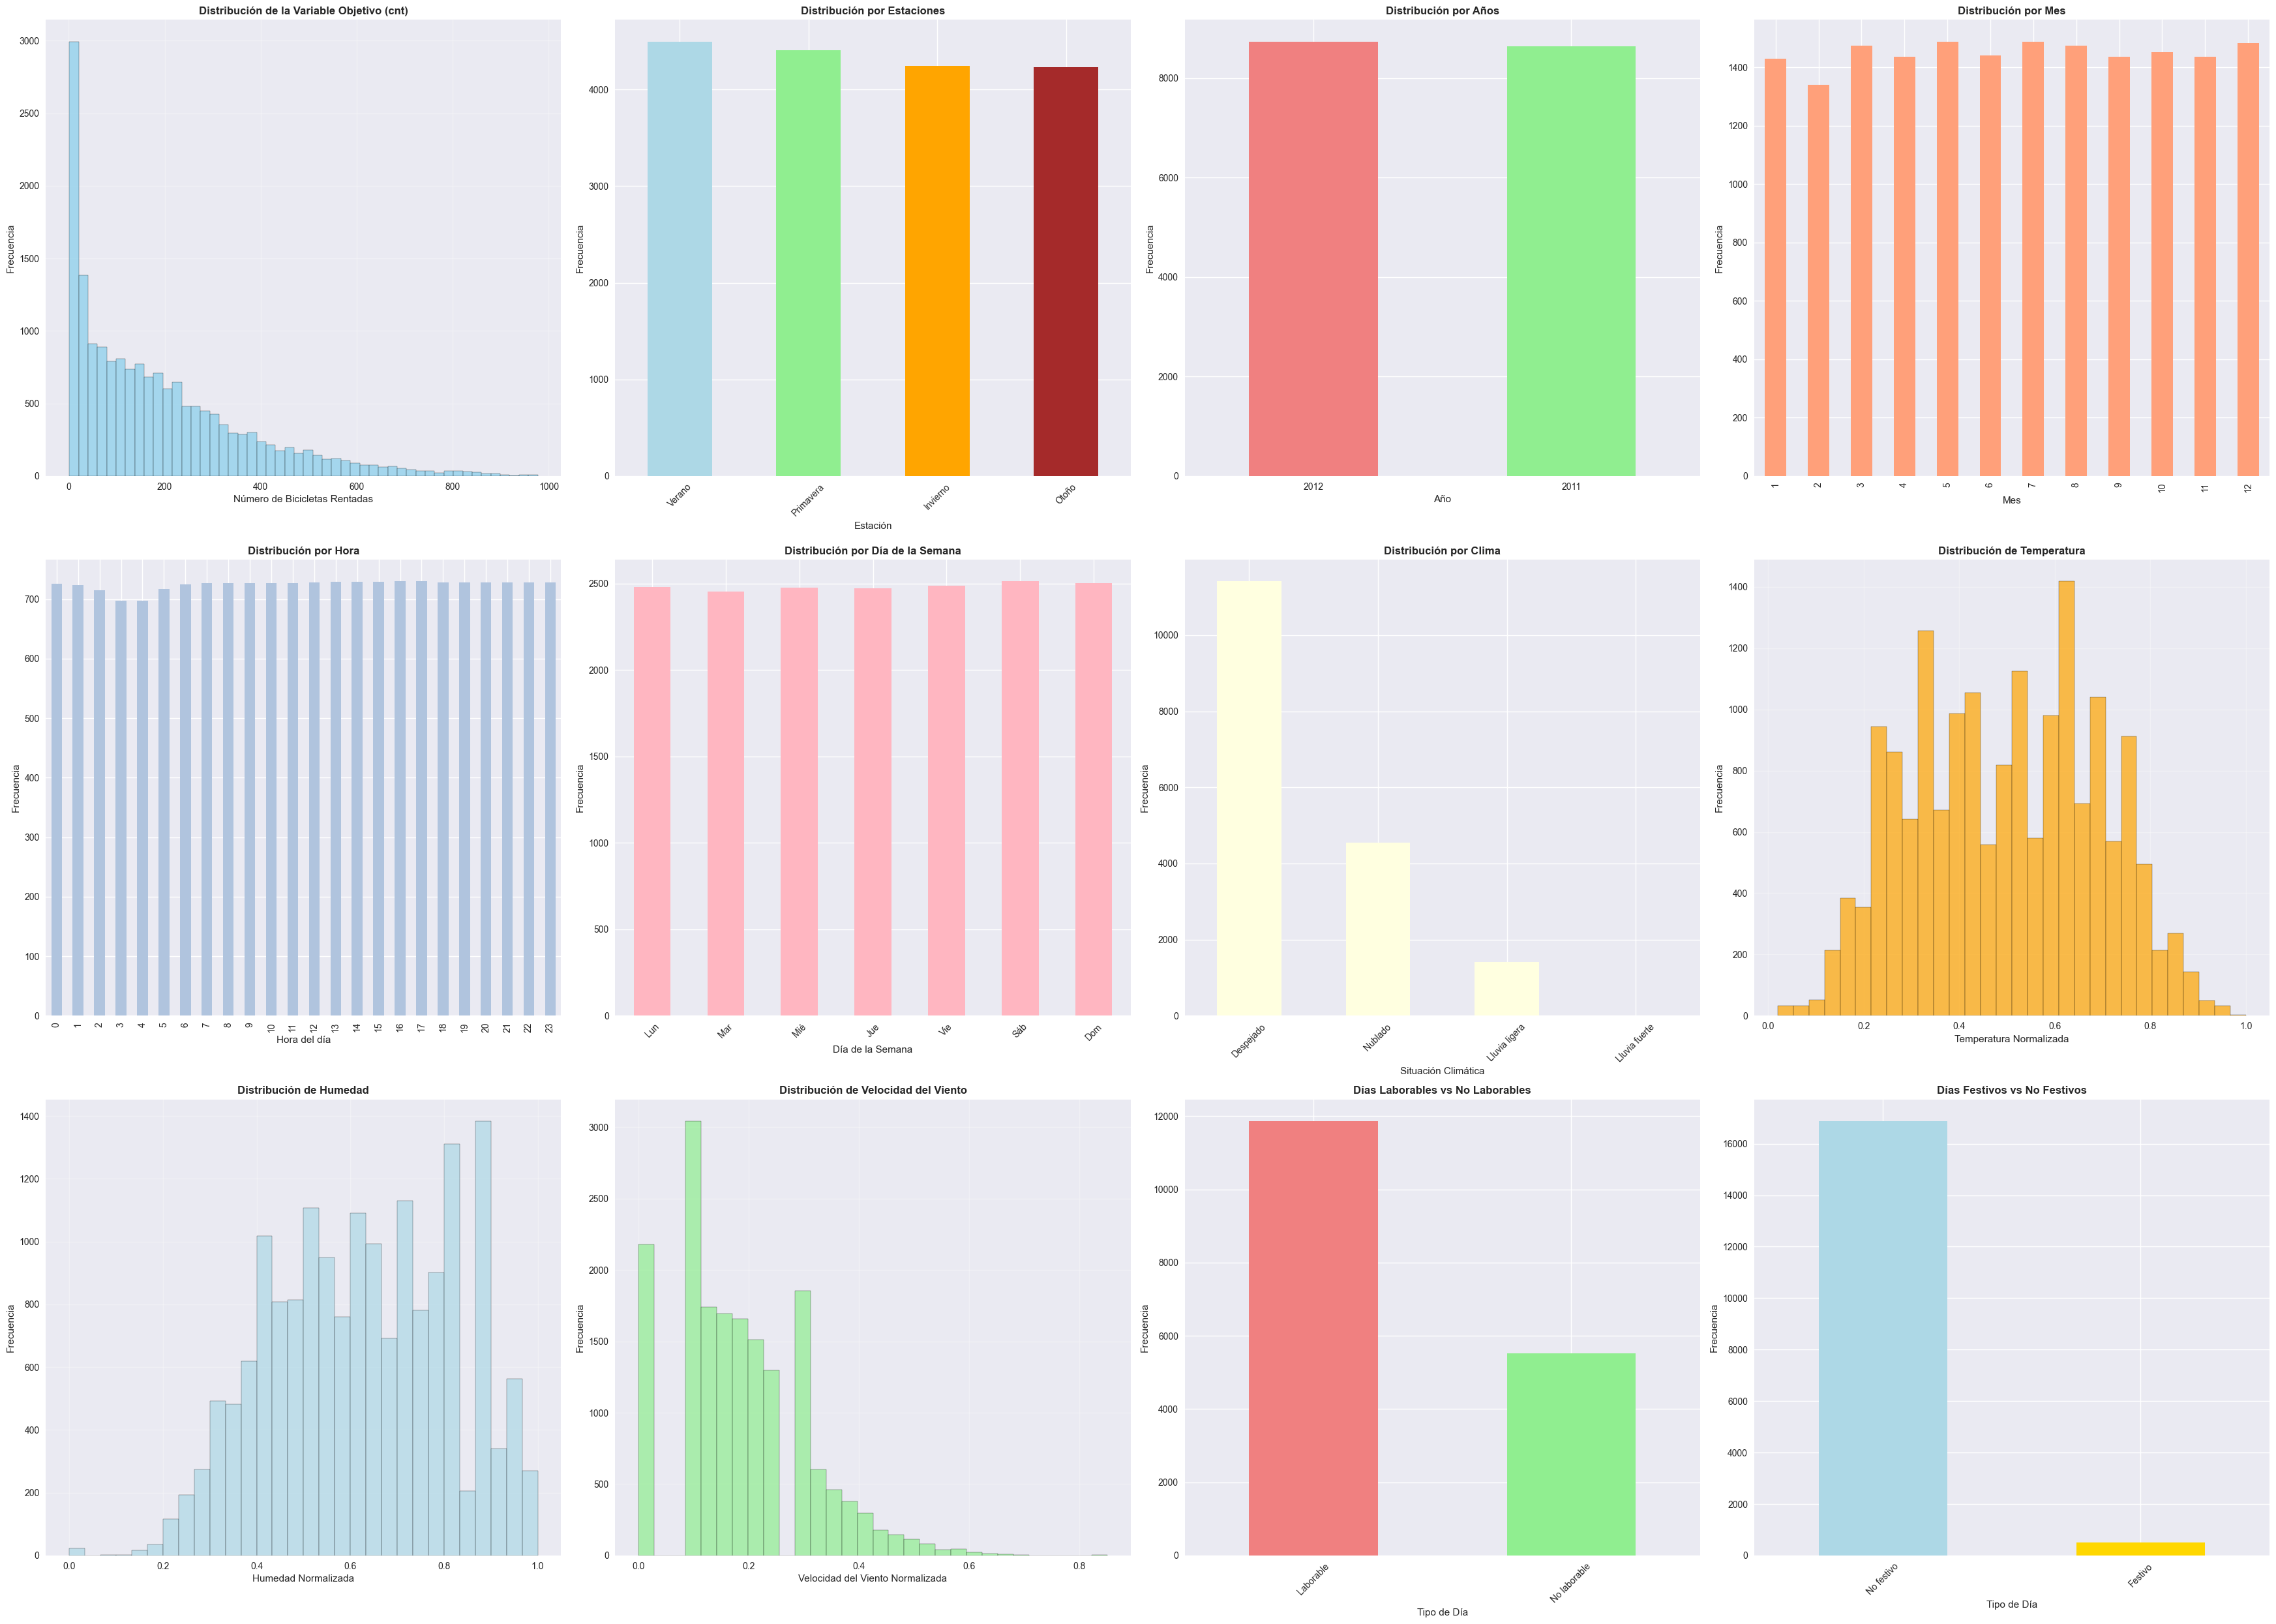

✅ Análisis de distribuciones completado


In [49]:
# 6. Análisis de distribuciones
print("📊 ANÁLISIS DE DISTRIBUCIONES")
print("=" * 50)

# Configurar el tamaño de las figuras
plt.figure(figsize=(35, 25))

# 1. Distribución de la variable objetivo
plt.subplot(3, 4, 1)
plt.hist(df['cnt'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribución de la Variable Objetivo (cnt)', fontsize=12, fontweight='bold')
plt.xlabel('Número de Bicicletas Rentadas')
plt.ylabel('Frecuencia')
plt.grid(alpha=0.3)

# 2. Distribución por estaciones
plt.subplot(3, 4, 2)
season_names = {1: 'Invierno', 2: 'Primavera', 3: 'Verano', 4: 'Otoño'}
df['season_name'] = df['season'].map(season_names)
df['season_name'].value_counts().plot(kind='bar', color=['lightblue', 'lightgreen', 'orange', 'brown'])
plt.title('Distribución por Estaciones', fontsize=12, fontweight='bold')
plt.xlabel('Estación')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)

# 3. Distribución por años
plt.subplot(3, 4, 3)
year_names = {0: '2011', 1: '2012'}
df['year_name'] = df['yr'].map(year_names)
df['year_name'].value_counts().plot(kind='bar', color=['lightcoral', 'lightgreen'])
plt.title('Distribución por Años', fontsize=12, fontweight='bold')
plt.xlabel('Año')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)

# 4. Distribución por mes
plt.subplot(3, 4, 4)
df['mnth'].value_counts().sort_index().plot(kind='bar', color='lightsalmon')
plt.title('Distribución por Mes', fontsize=12, fontweight='bold')
plt.xlabel('Mes')
plt.ylabel('Frecuencia')

# 5. Distribución por hora
plt.subplot(3, 4, 5)
df['hr'].value_counts().sort_index().plot(kind='bar', color='lightsteelblue')
plt.title('Distribución por Hora', fontsize=12, fontweight='bold')
plt.xlabel('Hora del día')
plt.ylabel('Frecuencia')

# 6. Distribución por día de la semana
plt.subplot(3, 4, 6)
weekday_names = {0: 'Dom', 1: 'Lun', 2: 'Mar', 3: 'Mié', 4: 'Jue', 5: 'Vie', 6: 'Sáb'}
df['weekday_name'] = df['weekday'].map(weekday_names)
df['weekday_name'].value_counts().reindex(['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']).plot(kind='bar', color='lightpink')
plt.title('Distribución por Día de la Semana', fontsize=12, fontweight='bold')
plt.xlabel('Día de la Semana')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)

# 7. Distribución por situación climática
plt.subplot(3, 4, 7)
weather_names = {1: 'Despejado', 2: 'Nublado', 3: 'Lluvia ligera', 4: 'Lluvia fuerte'}
df['weather_name'] = df['weathersit'].map(weather_names)
df['weather_name'].value_counts().plot(kind='bar', color='lightyellow')
plt.title('Distribución por Clima', fontsize=12, fontweight='bold')
plt.xlabel('Situación Climática')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)

# 8. Distribución de temperatura
plt.subplot(3, 4, 8)
plt.hist(df['temp'], bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.title('Distribución de Temperatura', fontsize=12, fontweight='bold')
plt.xlabel('Temperatura Normalizada')
plt.ylabel('Frecuencia')
plt.grid(alpha=0.3)

# 9. Distribución de humedad
plt.subplot(3, 4, 9)
plt.hist(df['hum'], bins=30, alpha=0.7, color='lightblue', edgecolor='black')
plt.title('Distribución de Humedad', fontsize=12, fontweight='bold')
plt.xlabel('Humedad Normalizada')
plt.ylabel('Frecuencia')
plt.grid(alpha=0.3)

# 10. Distribución de velocidad del viento
plt.subplot(3, 4, 10)
plt.hist(df['windspeed'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Distribución de Velocidad del Viento', fontsize=12, fontweight='bold')
plt.xlabel('Velocidad del Viento Normalizada')
plt.ylabel('Frecuencia')
plt.grid(alpha=0.3)

# 11. Distribución días laborables vs no laborables
plt.subplot(3, 4, 11)
workingday_names = {0: 'No laborable', 1: 'Laborable'}
df['workingday_name'] = df['workingday'].map(workingday_names)
df['workingday_name'].value_counts().plot(kind='bar', color=['lightcoral', 'lightgreen'])
plt.title('Días Laborables vs No Laborables', fontsize=12, fontweight='bold')
plt.xlabel('Tipo de Día')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)

# 12. Distribución días festivos
plt.subplot(3, 4, 12)
holiday_names = {0: 'No festivo', 1: 'Festivo'}
df['holiday_name'] = df['holiday'].map(holiday_names)
df['holiday_name'].value_counts().plot(kind='bar', color=['lightblue', 'gold'])
plt.title('Días Festivos vs No Festivos', fontsize=12, fontweight='bold')
plt.xlabel('Tipo de Día')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("✅ Análisis de distribuciones completado")

## 1.6 Análisis de patrones temporales

⏰ ANÁLISIS DE PATRONES TEMPORALES


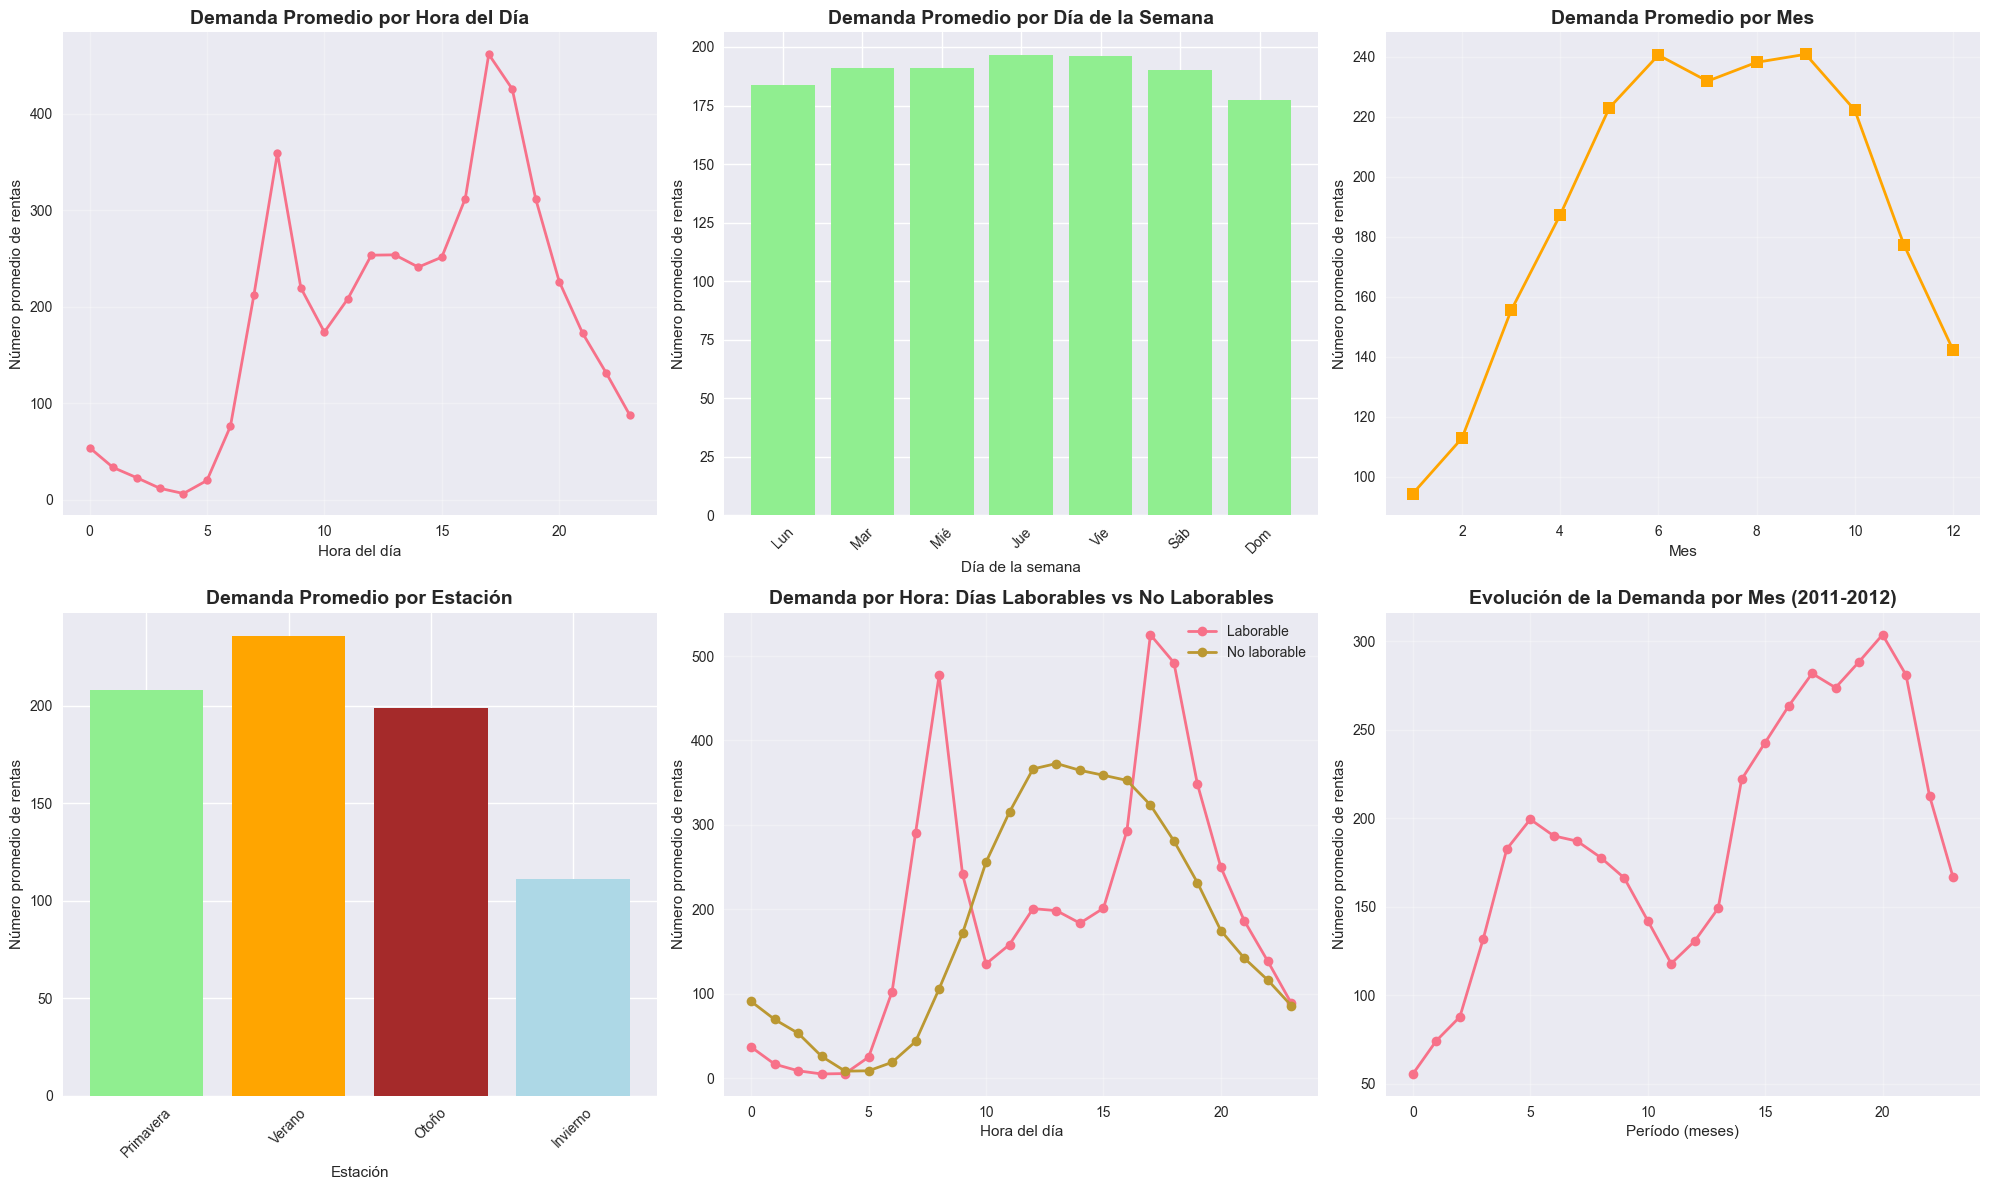


📊 ESTADÍSTICAS DE PATRONES TEMPORALES:
🕐 Hora con mayor demanda: 17:00 (461 rentas promedio)
🕐 Hora con menor demanda: 4:00 (6 rentas promedio)
📅 Día de la semana con mayor demanda: Jue (196 rentas promedio)
📅 Día de la semana con menor demanda: Dom (177 rentas promedio)
🗓️ Mes con mayor demanda: 9 (241 rentas promedio)
🗓️ Mes con menor demanda: 1 (94 rentas promedio)
🌱 Estación con mayor demanda: Verano (236 rentas promedio)
🌱 Estación con menor demanda: Invierno (111 rentas promedio)


In [46]:
# 7. Análisis de patrones temporales
print("⏰ ANÁLISIS DE PATRONES TEMPORALES")
print("=" * 50)

# Convertir la fecha a datetime
df['dteday'] = pd.to_datetime(df['dteday'])

# Crear visualizaciones de patrones temporales
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Demanda promedio por hora del día
hourly_avg = df.groupby('hr')['cnt'].mean()
axes[0, 0].plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, markersize=6)
axes[0, 0].set_title('Demanda Promedio por Hora del Día', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Hora del día')
axes[0, 0].set_ylabel('Número promedio de rentas')
axes[0, 0].grid(alpha=0.3)

# 2. Demanda promedio por día de la semana
weekday_avg = df.groupby('weekday_name')['cnt'].mean().reindex(['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom'])
axes[0, 1].bar(weekday_avg.index, weekday_avg.values, color='lightgreen')
axes[0, 1].set_title('Demanda Promedio por Día de la Semana', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Día de la semana')
axes[0, 1].set_ylabel('Número promedio de rentas')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Demanda promedio por mes
monthly_avg = df.groupby('mnth')['cnt'].mean()
axes[0, 2].plot(monthly_avg.index, monthly_avg.values, marker='s', linewidth=2, markersize=8, color='orange')
axes[0, 2].set_title('Demanda Promedio por Mes', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Mes')
axes[0, 2].set_ylabel('Número promedio de rentas')
axes[0, 2].grid(alpha=0.3)

# 4. Demanda promedio por estación
season_avg = df.groupby('season_name')['cnt'].mean().reindex(['Primavera', 'Verano', 'Otoño', 'Invierno'])
axes[1, 0].bar(season_avg.index, season_avg.values, color=['lightgreen', 'orange', 'brown', 'lightblue'])
axes[1, 0].set_title('Demanda Promedio por Estación', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Estación')
axes[1, 0].set_ylabel('Número promedio de rentas')
axes[1, 0].tick_params(axis='x', rotation=45)

# 5. Comparación entre días laborables y no laborables
workingday_comparison = df.groupby(['workingday_name', 'hr'])['cnt'].mean().unstack(level=0)
workingday_comparison.plot(ax=axes[1, 1], marker='o', linewidth=2)
axes[1, 1].set_title('Demanda por Hora: Días Laborables vs No Laborables', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Hora del día')
axes[1, 1].set_ylabel('Número promedio de rentas')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# 6. Evolución temporal a lo largo de los años
df['year_month'] = df['dteday'].dt.to_period('M')
monthly_trend = df.groupby('year_month')['cnt'].mean()
axes[1, 2].plot(range(len(monthly_trend)), monthly_trend.values, marker='o', linewidth=2)
axes[1, 2].set_title('Evolución de la Demanda por Mes (2011-2012)', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Período (meses)')
axes[1, 2].set_ylabel('Número promedio de rentas')
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas de patrones temporales
print("\n📊 ESTADÍSTICAS DE PATRONES TEMPORALES:")
print(f"🕐 Hora con mayor demanda: {hourly_avg.idxmax()}:00 ({hourly_avg.max():.0f} rentas promedio)")
print(f"🕐 Hora con menor demanda: {hourly_avg.idxmin()}:00 ({hourly_avg.min():.0f} rentas promedio)")
print(f"📅 Día de la semana con mayor demanda: {weekday_avg.idxmax()} ({weekday_avg.max():.0f} rentas promedio)")
print(f"📅 Día de la semana con menor demanda: {weekday_avg.idxmin()} ({weekday_avg.min():.0f} rentas promedio)")
print(f"🗓️ Mes con mayor demanda: {monthly_avg.idxmax()} ({monthly_avg.max():.0f} rentas promedio)")
print(f"🗓️ Mes con menor demanda: {monthly_avg.idxmin()} ({monthly_avg.min():.0f} rentas promedio)")
print(f"🌱 Estación con mayor demanda: {season_avg.idxmax()} ({season_avg.max():.0f} rentas promedio)")
print(f"🌱 Estación con menor demanda: {season_avg.idxmin()} ({season_avg.min():.0f} rentas promedio)")

## 1.7 Análisis de correlaciones

🔗 ANÁLISIS DE CORRELACIONES


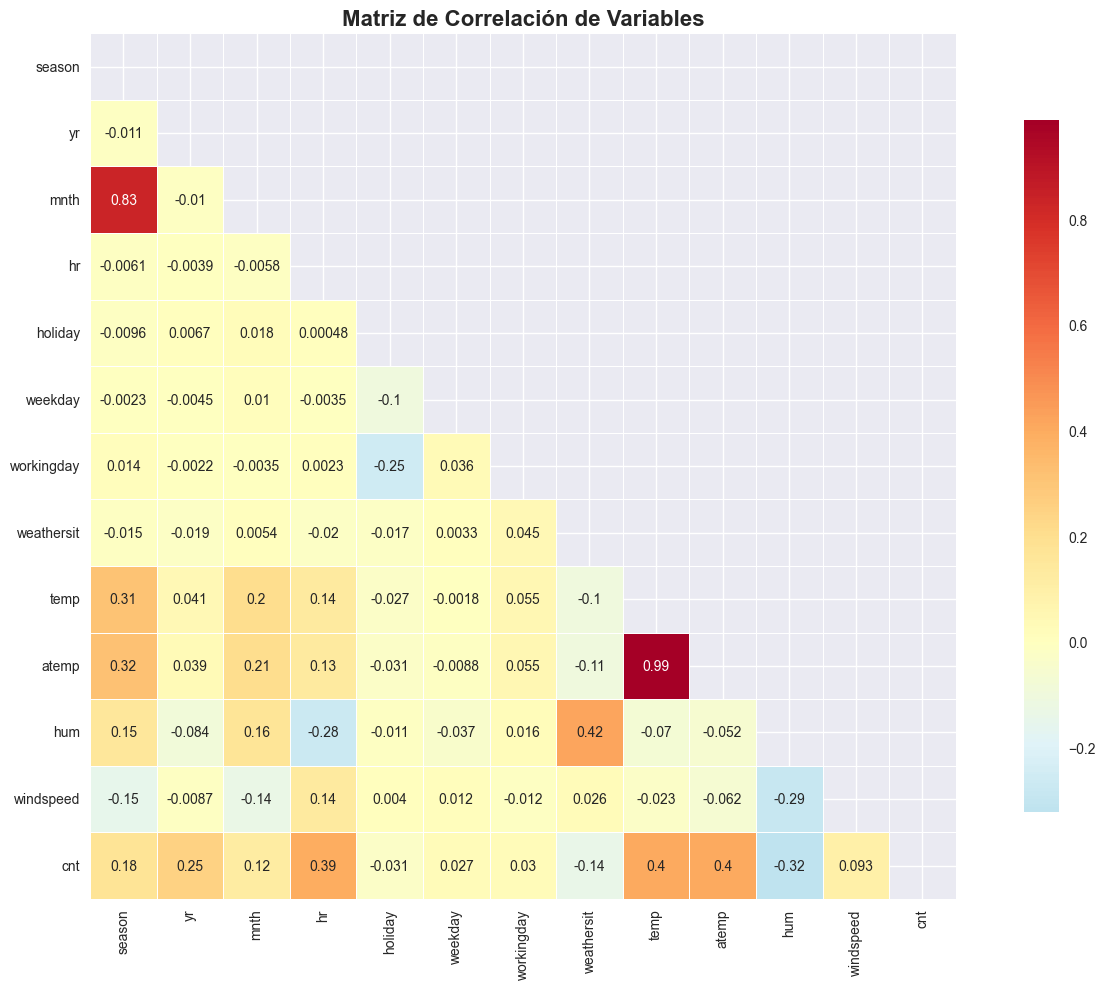


🎯 CORRELACIONES CON LA VARIABLE OBJETIVO (cnt):
cnt           1.000000
temp          0.404772
atemp         0.400929
hr            0.394071
hum          -0.322911
yr            0.250495
season        0.178056
weathersit   -0.142426
mnth          0.120638
windspeed     0.093234
holiday      -0.030927
workingday    0.030284
weekday       0.026900

📊 TOP 5 VARIABLES MÁS CORRELACIONADAS CON LA DEMANDA:
• temp: 0.405 (correlación positiva)
• atemp: 0.401 (correlación positiva)
• hr: 0.394 (correlación positiva)
• hum: -0.323 (correlación negativa)
• yr: 0.250 (correlación positiva)

⚠️ CORRELACIONES FUERTES ENTRE VARIABLES INDEPENDIENTES (posible multicolinealidad):
• season - mnth: 0.830
• temp - atemp: 0.988

🌡️ CORRELACIÓN TEMPERATURA vs TEMPERATURA APARENTE: 0.988
Esto indica una relación muy fuerte, se puede considerar usar solo una de estas variables.


In [51]:
# 8. Análisis de correlaciones
print("🔗 ANÁLISIS DE CORRELACIONES")
print("=" * 50)

# Usar la función definida para crear la matriz de correlación
correlation_matrix = plot_correlation_matrix(df, figsize=(14, 10))

# Análisis detallado de correlaciones con la variable objetivo
print("\n🎯 CORRELACIONES CON LA VARIABLE OBJETIVO (cnt):")
target_correlations = correlation_matrix['cnt'].sort_values(key=abs, ascending=False)
print(target_correlations.to_string())

print("\n📊 TOP 5 VARIABLES MÁS CORRELACIONADAS CON LA DEMANDA:")
top_correlations = target_correlations.drop('cnt').head(5)
for variable, correlation in top_correlations.items():
    direction = "positiva" if correlation > 0 else "negativa"
    print(f"• {variable}: {correlation:.3f} (correlación {direction})")

print("\n⚠️ CORRELACIONES FUERTES ENTRE VARIABLES INDEPENDIENTES (posible multicolinealidad):")
strong_correlations = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        correlation = correlation_matrix.iloc[i, j]
        if abs(correlation) > 0.7 and correlation_matrix.columns[i] != 'cnt' and correlation_matrix.columns[j] != 'cnt':
            strong_correlations.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation))

if strong_correlations:
    for var1, var2, corr in strong_correlations:
        print(f"• {var1} - {var2}: {corr:.3f}")
else:
    print("No se encontraron correlaciones fuertes (>0.7) entre variables independientes")

# Análisis específico entre temperatura y temperatura aparente
print(f"\n🌡️ CORRELACIÓN TEMPERATURA vs TEMPERATURA APARENTE: {correlation_matrix.loc['temp', 'atemp']:.3f}")
print("Esto indica una relación muy fuerte, se puede considerar usar solo una de estas variables.")

## 1.8 Análisis del impacto del clima en la demanda

🌤️ ANÁLISIS DEL IMPACTO CLIMÁTICO


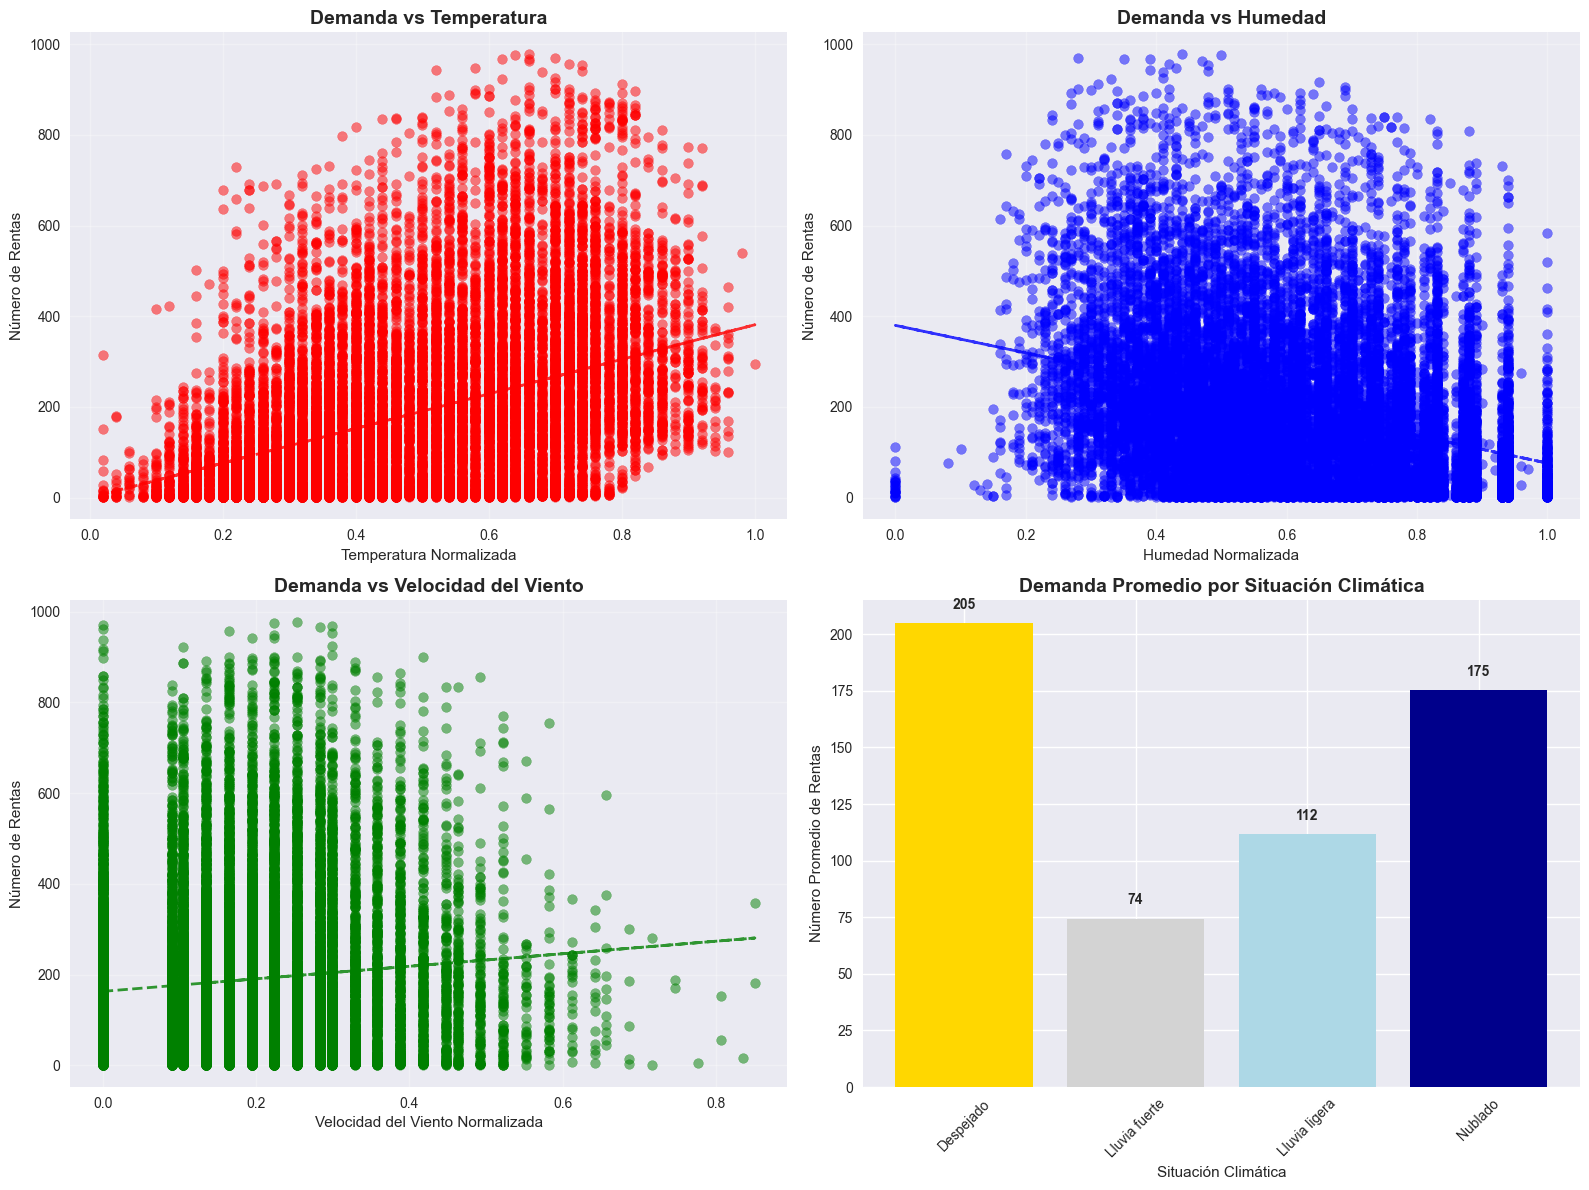


📊 ESTADÍSTICAS POR CONDICIÓN CLIMÁTICA:
               count    mean     std  min  max
weather_name                                  
Despejado      11413  204.87  189.49    1  977
Lluvia fuerte      3   74.33   77.93   23  164
Lluvia ligera   1419  111.58  133.78    1  891
Nublado         4544  175.17  165.43    1  957

🌡️ RANGOS DE TEMPERATURA Y SU IMPACTO:
            count    mean
temp_range               
Muy Fría     1070   65.07
Fría         5357  123.07
Templada     5117  194.67
Cálida       5126  260.70
Muy Cálida    709  326.28

💧 IMPACTO DE LA HUMEDAD:
Correlación humedad-demanda: -0.323
Demanda promedio con alta humedad (>70%): 127
Demanda promedio con baja humedad (≤70%): 227
Diferencia: 100 rentas menos con alta humedad


In [52]:
# 9. Análisis del impacto del clima en la demanda
print("🌤️ ANÁLISIS DEL IMPACTO CLIMÁTICO")
print("=" * 50)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Demanda vs Temperatura
axes[0, 0].scatter(df['temp'], df['cnt'], alpha=0.5, color='red')
axes[0, 0].set_title('Demanda vs Temperatura', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Temperatura Normalizada')
axes[0, 0].set_ylabel('Número de Rentas')
axes[0, 0].grid(alpha=0.3)

# Añadir línea de tendencia
z = np.polyfit(df['temp'], df['cnt'], 1)
p = np.poly1d(z)
axes[0, 0].plot(df['temp'], p(df['temp']), "r--", alpha=0.8, linewidth=2)

# 2. Demanda vs Humedad
axes[0, 1].scatter(df['hum'], df['cnt'], alpha=0.5, color='blue')
axes[0, 1].set_title('Demanda vs Humedad', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Humedad Normalizada')
axes[0, 1].set_ylabel('Número de Rentas')
axes[0, 1].grid(alpha=0.3)

# Añadir línea de tendencia
z = np.polyfit(df['hum'], df['cnt'], 1)
p = np.poly1d(z)
axes[0, 1].plot(df['hum'], p(df['hum']), "b--", alpha=0.8, linewidth=2)

# 3. Demanda vs Velocidad del viento
axes[1, 0].scatter(df['windspeed'], df['cnt'], alpha=0.5, color='green')
axes[1, 0].set_title('Demanda vs Velocidad del Viento', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Velocidad del Viento Normalizada')
axes[1, 0].set_ylabel('Número de Rentas')
axes[1, 0].grid(alpha=0.3)

# Añadir línea de tendencia
z = np.polyfit(df['windspeed'], df['cnt'], 1)
p = np.poly1d(z)
axes[1, 0].plot(df['windspeed'], p(df['windspeed']), "g--", alpha=0.8, linewidth=2)

# 4. Demanda promedio por situación climática
weather_avg = df.groupby('weather_name')['cnt'].mean()
bars = axes[1, 1].bar(weather_avg.index, weather_avg.values, 
                      color=['gold', 'lightgray', 'lightblue', 'darkblue'])
axes[1, 1].set_title('Demanda Promedio por Situación Climática', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Situación Climática')
axes[1, 1].set_ylabel('Número Promedio de Rentas')
axes[1, 1].tick_params(axis='x', rotation=45)

# Añadir valores en las barras
for bar in bars:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 5,
                    f'{height:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Estadísticas por condición climática
print("\n📊 ESTADÍSTICAS POR CONDICIÓN CLIMÁTICA:")
weather_stats = df.groupby('weather_name')['cnt'].agg(['count', 'mean', 'std', 'min', 'max']).round(2)
print(weather_stats)

print("\n🌡️ RANGOS DE TEMPERATURA Y SU IMPACTO:")
# Crear bins de temperatura
df['temp_range'] = pd.cut(df['temp'], bins=5, labels=['Muy Fría', 'Fría', 'Templada', 'Cálida', 'Muy Cálida'])
temp_impact = df.groupby('temp_range')['cnt'].agg(['count', 'mean']).round(2)
print(temp_impact)

print(f"\n💧 IMPACTO DE LA HUMEDAD:")
print(f"Correlación humedad-demanda: {df['hum'].corr(df['cnt']):.3f}")
high_humidity = df[df['hum'] > 0.7]['cnt'].mean()
low_humidity = df[df['hum'] <= 0.7]['cnt'].mean()
print(f"Demanda promedio con alta humedad (>70%): {high_humidity:.0f}")
print(f"Demanda promedio con baja humedad (≤70%): {low_humidity:.0f}")
print(f"Diferencia: {low_humidity - high_humidity:.0f} rentas menos con alta humedad")

## 1.9 Detección Completa de Outliers

In [8]:
df.columns.to_list()

['dteday',
 'season',
 'yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'cnt']

In [12]:
### 1.2.2 Identifique y reporte outliers en al menos 3 variables numéricas
# ========================

print(f"\n⚠️  ANÁLISIS DE OUTLIERS:")

# Detectar outliers usando IQR
def detect_outliers_iqr(df, columns):
    outliers_count = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_count[col] = len(outliers)
    return outliers_count

main_features = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']

outliers_info = detect_outliers_iqr(df, main_features)
print(f"\n📊 CONTEO DE OUTLIERS POR VARIABLE (método IQR):")
for feature, count in outliers_info.items():
    print(f"   • {feature:<25}: {count:3d} outliers")


⚠️  ANÁLISIS DE OUTLIERS:

📊 CONTEO DE OUTLIERS POR VARIABLE (método IQR):
   • season                   :   0 outliers
   • yr                       :   0 outliers
   • mnth                     :   0 outliers
   • hr                       :   0 outliers
   • holiday                  : 500 outliers
   • weekday                  :   0 outliers
   • workingday               :   0 outliers
   • weathersit               :   3 outliers
   • temp                     :   0 outliers
   • atemp                    :   0 outliers
   • hum                      :  22 outliers
   • windspeed                : 342 outliers
